https://github.com/timesler/facenet-pytorch/blob/master/examples/finetune.ipynb 

In [46]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch import nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models
import numpy as np
import os

from sklearn.metrics import accuracy_score,f1_score,precision_score
from torchsummaryX import summary
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
import wandb

wandb.init(project="milestone2_inception")

In [47]:
#data_dir = './data/lfw'
data_dir = '/data_seoul/dain5832/cmu/summer/celebA/celeba'

batch_size = 128
epochs = 20
workers = 0 if os.name == 'nt' else 8

wandb.config.batch_size = batch_size
wandb.config.epochs = epochs

In [48]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


## InceptionResnetV1

In [49]:
class InceptionResnetV1_multilabel(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.resnet = InceptionResnetV1(
            classify=True,
            pretrained='vggface2',
            num_classes=n_classes
        )
        #self.resnet = models.resnet34(pretrained=True)
        #num_ftrs = self.resnet.fc.in_features
        #self.resnet.fc = nn.Linear(num_ftrs, n_classes)

    def forward(self, x):
        return self.resnet(x)

# Initialize the model
model = InceptionResnetV1_multilabel(40).to(device)

In [50]:
optimizer = optim.Adam(model.parameters(), lr=0.002)
scheduler = MultiStepLR(optimizer, [5, 10])

wandb.config.lr = 0.002
wandb.config.optim = 'Adam'

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
#dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)
dataset = datasets.CelebA(root='/data_seoul/dain5832/cmu/summer/celebA', split='valid', target_type='attr', transform=trans)

img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_inds)
)

In [51]:
for (x,y) in train_loader:
    print(x.shape, y.shape)
    break
summary(model, x.to(device))

torch.Size([128, 3, 218, 178]) torch.Size([128, 40])
                                                     Kernel Shape  \
Layer                                                               
0_resnet.conv2d_1a.Conv2d_conv                      [3, 32, 3, 3]   
1_resnet.conv2d_1a.BatchNorm2d_bn                            [32]   
2_resnet.conv2d_1a.ReLU_relu                                    -   
3_resnet.conv2d_2a.Conv2d_conv                     [32, 32, 3, 3]   
4_resnet.conv2d_2a.BatchNorm2d_bn                            [32]   
5_resnet.conv2d_2a.ReLU_relu                                    -   
6_resnet.conv2d_2b.Conv2d_conv                     [32, 64, 3, 3]   
7_resnet.conv2d_2b.BatchNorm2d_bn                            [64]   
8_resnet.conv2d_2b.ReLU_relu                                    -   
9_resnet.MaxPool2d_maxpool_3a                                   -   
10_resnet.conv2d_3b.Conv2d_conv                    [64, 80, 1, 1]   
11_resnet.conv2d_3b.BatchNorm2d_bn                

/data_seoul/dain5832/anaconda3/envs/cmu-deeplearning/lib/python3.9/site-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_resnet.conv2d_1a.Conv2d_conv,"[3, 32, 3, 3]","[128, 32, 108, 88]",864.0,8211456.0
1_resnet.conv2d_1a.BatchNorm2d_bn,[32],"[128, 32, 108, 88]",64.0,32.0
2_resnet.conv2d_1a.ReLU_relu,-,"[128, 32, 108, 88]",NaN,NaN
3_resnet.conv2d_2a.Conv2d_conv,"[32, 32, 3, 3]","[128, 32, 106, 86]",9216.0,84013056.0
4_resnet.conv2d_2a.BatchNorm2d_bn,[32],"[128, 32, 106, 86]",64.0,32.0
...,...,...,...,...
377_resnet.AdaptiveAvgPool2d_avgpool_1a,-,"[128, 1792, 1, 1]",NaN,NaN
378_resnet.Dropout_dropout,-,"[128, 1792, 1, 1]",NaN,NaN
379_resnet.Linear_last_linear,"[1792, 512]","[128, 512]",917504.0,917504.0


In [52]:
for (x,y) in val_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 3, 218, 178]) torch.Size([128, 40])


In [53]:
loss_fn = torch.nn.BCEWithLogitsLoss()
metrics = {
}

In [54]:
def pass_epoch(
    model, loss_fn, loader, optimizer=None, scheduler=None,
    batch_metrics={}, show_running=True,
    device='cpu', writer=None
):
    """Train or evaluate over a data epoch.
    
    Arguments:
        model {torch.nn.Module} -- Pytorch model.
        loss_fn {callable} -- A function to compute (scalar) loss.
        loader {torch.utils.data.DataLoader} -- A pytorch data loader.
    
    Keyword Arguments:
        optimizer {torch.optim.Optimizer} -- A pytorch optimizer.
        scheduler {torch.optim.lr_scheduler._LRScheduler} -- LR scheduler (default: {None})
        batch_metrics {dict} -- Dictionary of metric functions to call on each batch. The default
            is a simple timer. A progressive average of these metrics, along with the average
            loss, is printed every batch. (default: {{'time': iter_timer()}})
        show_running {bool} -- Whether or not to print losses and metrics for the current batch
            or rolling averages. (default: {False})
        device {str or torch.device} -- Device for pytorch to use. (default: {'cpu'})
        writer {torch.utils.tensorboard.SummaryWriter} -- Tensorboard SummaryWriter. (default: {None})
    
    Returns:
        tuple(torch.Tensor, dict) -- A tuple of the average loss and a dictionary of average
            metric values across the epoch.
    """
    
    mode = 'Train' if model.training else 'Valid'
    logger = training.Logger(mode, length=len(loader), calculate_mean=show_running)
    loss = 0
    metrics = {}
    history = {'loss':[], 'f1':[], 'acc':[], 'precision':[], 'val_loss':[], 'val_f1':[], 'val_acc':[], 'val_precision':[]}
    y_preds, targets = [], []
    for i_batch, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        prediction=torch.round(torch.sigmoid(y_pred))
        y_preds.append(prediction.detach().cpu())
        targets.append(y.detach().cpu())
        loss_batch = loss_fn(y_pred.to(torch.float32), y.to(torch.float32))

        if model.training:
            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()

        metrics_batch = {}
        for metric_name, metric_fn in batch_metrics.items():
            if metric_name == 'fps':
                metrics_batch[metric_name] = metric_fn(y_pred.detach().cpu().numpy(), y.detach().cpu().numpy()).detach().cpu()
                metrics[metric_name] = metrics.get(metric_name, 0) + metrics_batch[metric_name]
            else:
                threshold = 0.5
                y_pred = np.array(y_pred.detach().cpu().numpy() > threshold, dtype=float)
                #print(y_pred)
                #print(y)
                metrics_batch[metric_name] = metric_fn(y_pred.astype(int), y.detach().cpu().numpy().astype(int))
                metrics[metric_name] = metrics.get(metric_name, 0) + metrics_batch[metric_name]
        
        if writer is not None and model.training:
            if writer.iteration % writer.interval == 0:
                writer.add_scalars('loss', {mode: loss_batch.detach().cpu()}, writer.iteration)
                for metric_name, metric_batch in metrics_batch.items():
                    writer.add_scalars(metric_name, {mode: metric_batch}, writer.iteration)
            writer.iteration += 1
        
        loss_batch = loss_batch.detach().cpu()
        loss += loss_batch
        if show_running:
            logger(loss, metrics, i_batch)
        else:
            logger(loss_batch, metrics_batch, i_batch)
    
    if model.training and scheduler is not None:
        scheduler.step()

    loss = loss / (i_batch + 1)
    metrics = {k: v / (i_batch + 1) for k, v in metrics.items()}
    f1=round(f1_score(torch.cat(targets,dim=0).numpy(),torch.cat(y_preds,dim=0).numpy(),average='samples'), 3)
    acc=round(accuracy_score(torch.cat(targets,dim=0).numpy(),torch.cat(y_preds,dim=0).numpy()), 3)
    precision = round(precision_score(torch.cat(targets,dim=0).numpy(),torch.cat(y_preds,dim=0).numpy(),average='samples'), 3)
    
    print('f1score:', f1)
    print('precision:', precision)
    if model.training:
        history['loss'].append(loss)
        history['f1'].append(f1)
        history['acc'].append(acc)
        history['precision'].append(precision)
        wandb.log({"loss": loss, "f1": f1, "precision":precision})

    else:
        history['val_loss'].append(loss)
        history['val_f1'].append(f1)
        history['val_acc'].append(acc)
        history['val_precision'].append(precision)
        wandb.log({"val_loss": loss, "val_f1": f1, "val_precision":precision})
    
    if writer is not None and not model.training:
        writer.add_scalars('loss', {mode: loss.detach()}, writer.iteration)
        for metric_name, metric in metrics.items():
            writer.add_scalars(metric_name, {mode: metric})

    return loss, metrics, history

In [55]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
model.eval()
pass_epoch(
    model, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

epochs = 20
for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    model.train()
    pass_epoch(
        model, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    model.eval()
    pass_epoch(
        model, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )
    model_name='inception'
    torch.save(model.state_dict(), 'model_{}_{}.pth'.format(model_name, epoch))

writer.close()



Initial
----------
Valid |    32/32   | loss:    0.7096 |    
f1score: 0.299
precision: 0.223

Epoch 1/20
----------
Train |   125/125  | loss:    0.3543 |    
f1score: 0.647
precision: 0.719
Valid |    32/32   | loss:    0.2673 |    
f1score: 0.709
precision: 0.757

Epoch 2/20
----------
Train |   125/125  | loss:    0.2349 |    
f1score: 0.729
precision: 0.83
Valid |    32/32   | loss:    0.2316 |    
f1score: 0.732
precision: 0.832

Epoch 3/20
----------
Train |   125/125  | loss:    0.2153 |    
f1score: 0.753
precision: 0.839
Valid |    32/32   | loss:    0.2321 |    
f1score: 0.729
precision: 0.823

Epoch 4/20
----------
Train |   125/125  | loss:    0.2022 |    
f1score: 0.77
precision: 0.846
Valid |    32/32   | loss:    0.2206 |    
f1score: 0.757
precision: 0.811

Epoch 5/20
----------
Train |   125/125  | loss:    0.1899 |    
f1score: 0.787
precision: 0.854
Valid |    32/32   | loss:    0.2310 |    
f1score: 0.755
precision: 0.782

Epoch 6/20
----------
Train |   125/125 

KeyboardInterrupt: 

## Test

In [22]:

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
#dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)
dataset = datasets.CelebA(root='/data_seoul/dain5832/cmu/summer/celebA', split='test', target_type='attr', transform=trans)

img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)

test_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(img_inds)
)

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

df_attr = pd.read_csv('/data_seoul/dain5832/cmu/summer/celebA/celeba/list_attr_celeba.txt', delim_whitespace=True, header=1)
df_attr.replace(-1,0,inplace=True)
df_attr.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


40


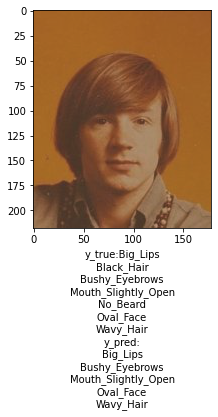

In [24]:
for (images, attr) in test_loader:
    idx= 0
    y_pred = model(images.to(device))
    prediction=torch.round(torch.sigmoid(y_pred)).detach().cpu()

    images=images.cpu().numpy().transpose((0,2,3,1))
    plt.imshow(images[idx]*[0.2644, 0.2436, 0.2397]+[0.5063, 0.4258, 0.3832])
    labels=df_attr.columns.tolist()
    labels=labels[1:]
    att=attr[idx].numpy()
    prediction = prediction[idx].numpy().astype(int)
    print(len(prediction))
    preds = ""
    for label,a in list(zip(labels,prediction)):
        if a== 1:
            preds+= "\n"+label
    labels="\n".join([label for label,a in list(zip(labels,att)) if a==1])
    plt.xlabel("y_true:"+labels+"\n"+"y_pred:"+preds)
    plt.show()
    break